# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

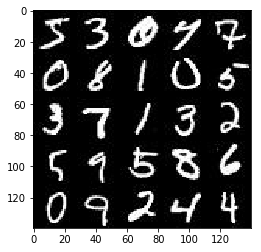

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

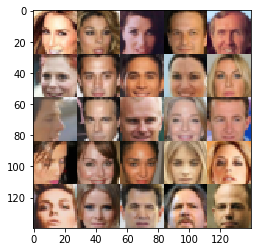

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.11.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_images")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, (None), name="learning_rate")
    
    return input_images, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha_relu = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        #input layer 28x28x3
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha_relu * x1, x1)
        # output 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        relu2 = tf.maximum(alpha_relu * x2, x2)
        #output 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same')
        relu3 = tf.maximum(alpha_relu * x3, x3)
        #output 4x4x256
        
        x4 = tf.layers.conv2d(relu3, 512, 4, strides=1, padding='same')
        relu4 = tf.maximum(alpha_relu * x4, x4)
        #output 4x4x512
        
        flattten = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(flattten, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha_relu = 0.2
    with tf.variable_scope("generator", reuse= not is_train):
        # fully connected layer 
        x1 = tf.layers.dense(z, 4*4*512)
        # convolution stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha_relu * x1, x1)
        # output 4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha_relu * x2, x2)
        # output 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha_relu * x3, x3)
        # output 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        #output 28x28xout_channel_dim
        
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake))
    )
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, lr:learning_rate})

                if steps % 100 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z:batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z:batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 200 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

                   

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2307... Generator Loss: 1.2439
Epoch 1/2... Discriminator Loss: 0.8634... Generator Loss: 0.8812


Epoch 1/2... Discriminator Loss: 1.0787... Generator Loss: 2.8172
Epoch 1/2... Discriminator Loss: 0.8869... Generator Loss: 1.3927


Epoch 1/2... Discriminator Loss: 0.9727... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 0.8210


Epoch 1/2... Discriminator Loss: 1.2387... Generator Loss: 0.7020
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 0.7247


Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.6125
Epoch 1/2... Discriminator Loss: 0.9596... Generator Loss: 0.9129


Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 0.6883
Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 1.0544


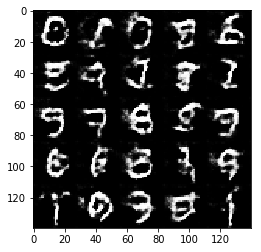

Epoch 1/2... Discriminator Loss: 1.2099... Generator Loss: 0.5823
Epoch 1/2... Discriminator Loss: 0.8675... Generator Loss: 1.0166


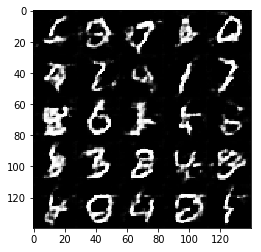

Epoch 1/2... Discriminator Loss: 0.8859... Generator Loss: 0.8762
Epoch 1/2... Discriminator Loss: 1.1756... Generator Loss: 0.7100


Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: 1.1988
Epoch 1/2... Discriminator Loss: 1.1238... Generator Loss: 1.1935


Epoch 1/2... Discriminator Loss: 0.7626... Generator Loss: 1.4086
Epoch 1/2... Discriminator Loss: 1.0744... Generator Loss: 0.7152


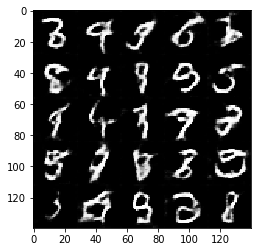

Epoch 1/2... Discriminator Loss: 0.9434... Generator Loss: 0.8939
Epoch 1/2... Discriminator Loss: 0.9866... Generator Loss: 0.6968


Epoch 1/2... Discriminator Loss: 0.9674... Generator Loss: 1.0414
Epoch 1/2... Discriminator Loss: 0.9880... Generator Loss: 1.2786


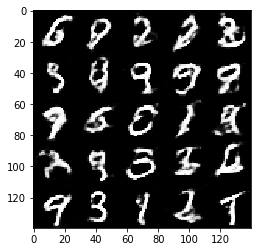

Epoch 1/2... Discriminator Loss: 0.8533... Generator Loss: 1.1194
Epoch 1/2... Discriminator Loss: 1.1572... Generator Loss: 0.8651


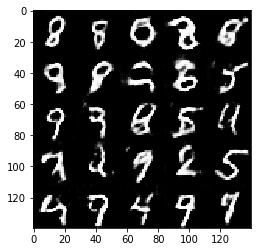

Epoch 1/2... Discriminator Loss: 0.9474... Generator Loss: 1.2264
Epoch 1/2... Discriminator Loss: 1.1195... Generator Loss: 0.9725


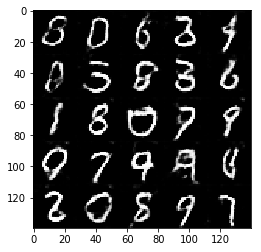

Epoch 1/2... Discriminator Loss: 0.8515... Generator Loss: 1.1825
Epoch 1/2... Discriminator Loss: 1.1715... Generator Loss: 0.7955


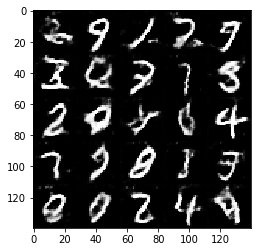

Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 0.8944
Epoch 1/2... Discriminator Loss: 1.0370... Generator Loss: 0.9868


Epoch 1/2... Discriminator Loss: 0.8368... Generator Loss: 1.1835
Epoch 1/2... Discriminator Loss: 0.7857... Generator Loss: 1.1427


Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 1.1993
Epoch 1/2... Discriminator Loss: 0.7521... Generator Loss: 1.2980


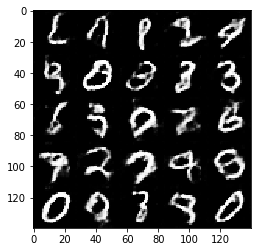

Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 1.1329
Epoch 2/2... Discriminator Loss: 1.2038... Generator Loss: 1.0701


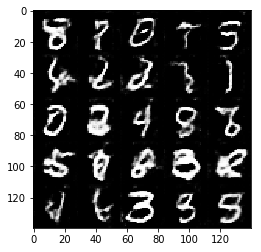

Epoch 2/2... Discriminator Loss: 0.6840... Generator Loss: 1.4140
Epoch 2/2... Discriminator Loss: 0.7528... Generator Loss: 1.2793


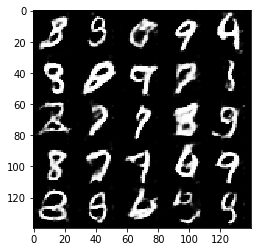

Epoch 2/2... Discriminator Loss: 0.5715... Generator Loss: 1.6024
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 1.2111


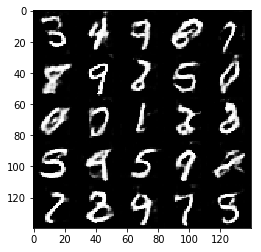

Epoch 2/2... Discriminator Loss: 1.0400... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 0.9016... Generator Loss: 0.9925


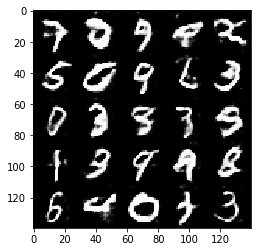

Epoch 2/2... Discriminator Loss: 0.9871... Generator Loss: 0.8918
Epoch 2/2... Discriminator Loss: 0.8832... Generator Loss: 0.8539


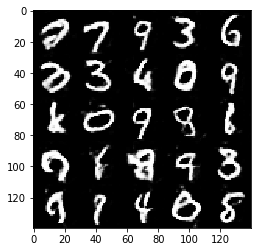

Epoch 2/2... Discriminator Loss: 0.6274... Generator Loss: 1.5369
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 1.3815


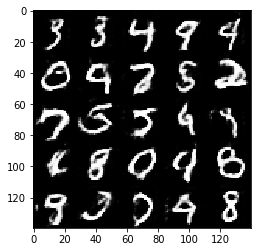

Epoch 2/2... Discriminator Loss: 1.3235... Generator Loss: 0.5906
Epoch 2/2... Discriminator Loss: 0.8927... Generator Loss: 1.1197


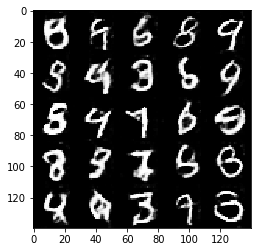

Epoch 2/2... Discriminator Loss: 0.9349... Generator Loss: 1.3911
Epoch 2/2... Discriminator Loss: 0.7925... Generator Loss: 1.0126


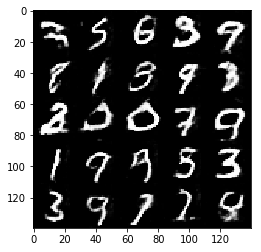

Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 0.9209
Epoch 2/2... Discriminator Loss: 1.0453... Generator Loss: 0.8119


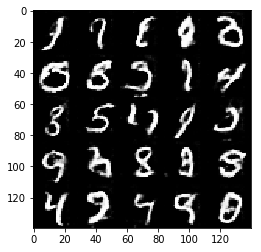

Epoch 2/2... Discriminator Loss: 1.3261... Generator Loss: 0.5772
Epoch 2/2... Discriminator Loss: 0.7619... Generator Loss: 1.1696


Epoch 2/2... Discriminator Loss: 0.8307... Generator Loss: 1.0083
Epoch 2/2... Discriminator Loss: 0.8245... Generator Loss: 1.0796


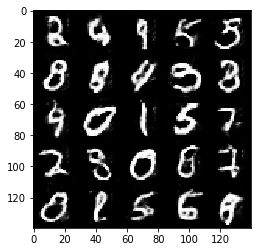

Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 1.1309
Epoch 2/2... Discriminator Loss: 0.8438... Generator Loss: 1.1653


Epoch 2/2... Discriminator Loss: 0.8919... Generator Loss: 1.2632
Epoch 2/2... Discriminator Loss: 0.9114... Generator Loss: 1.0933


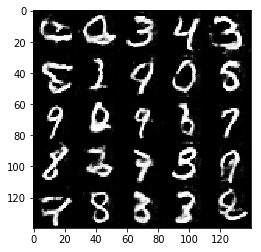

Epoch 2/2... Discriminator Loss: 0.8719... Generator Loss: 0.9942
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 0.9305


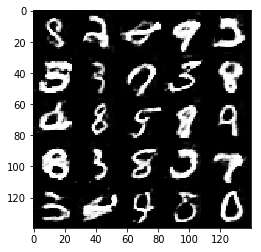

Epoch 2/2... Discriminator Loss: 1.0512... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 1.0750... Generator Loss: 1.2257


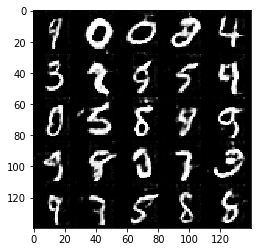

Epoch 2/2... Discriminator Loss: 0.7730... Generator Loss: 1.0518
Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 0.8121


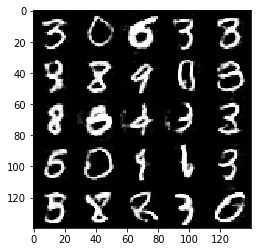

Epoch 2/2... Discriminator Loss: 1.0048... Generator Loss: 0.9645
Epoch 2/2... Discriminator Loss: 0.9429... Generator Loss: 0.7052


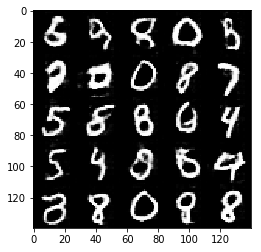

Epoch 2/2... Discriminator Loss: 0.7354... Generator Loss: 1.2958
Epoch 2/2... Discriminator Loss: 0.6639... Generator Loss: 1.0849


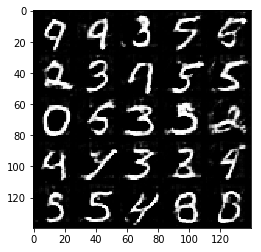

Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.1214
Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 1.1252


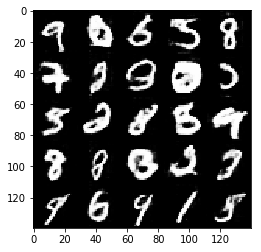

Epoch 2/2... Discriminator Loss: 0.6827... Generator Loss: 1.4875


In [26]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 0.2801... Generator Loss: 1.7128


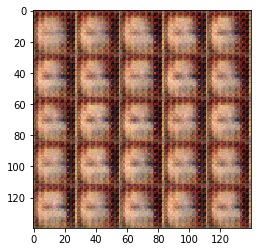

Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 1.3422
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.8074


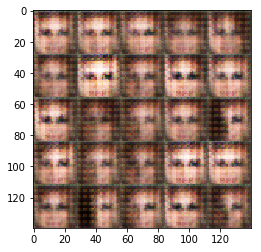

Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.8633


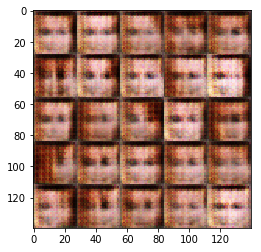

Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7385


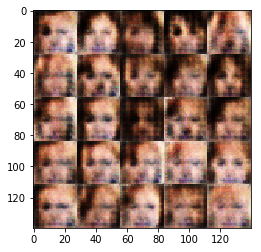

Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.8077


Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7578


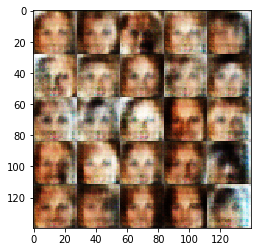

Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.6797


Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.7090


Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.6615


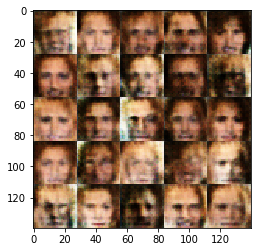

Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.7241


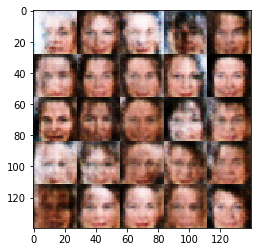

Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.6756


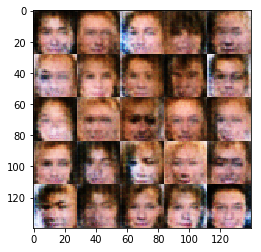

Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.7005


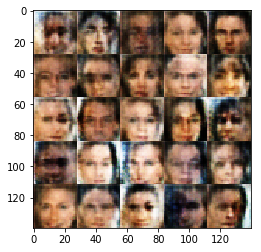

Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.6657


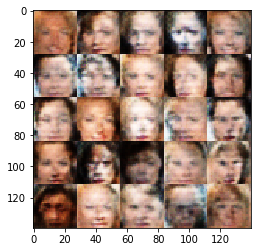

Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7333


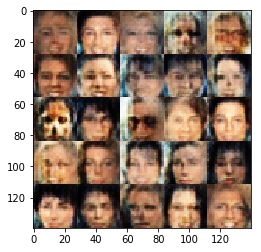

Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6664


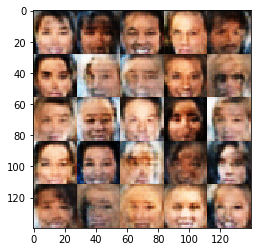

Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6214


Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6926


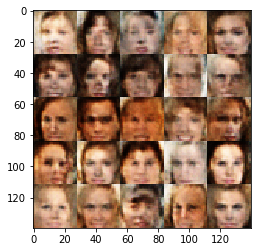

Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.8199


Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7592


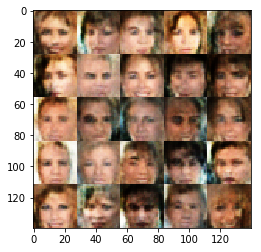

Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.9118


Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.6807


Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.6889


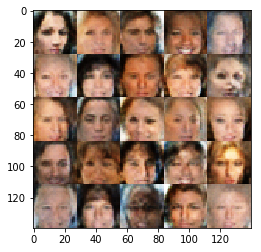

Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.7429


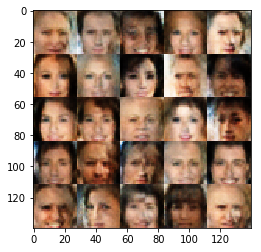

Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6120


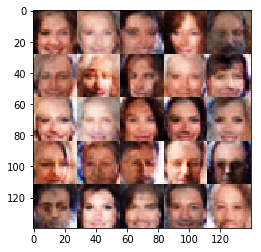

Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.7363


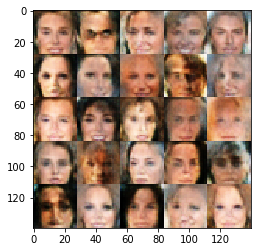

Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.7693


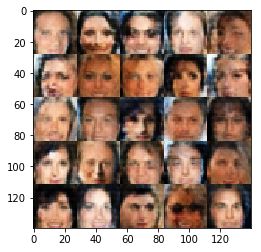

Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.8175


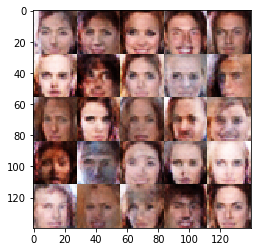

Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.6625


Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.8890


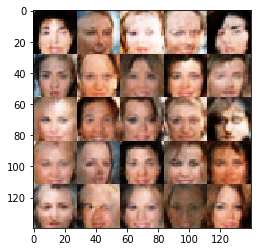

Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.8091


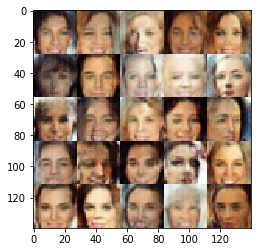

Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.8082


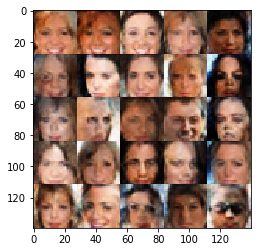

Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.6134


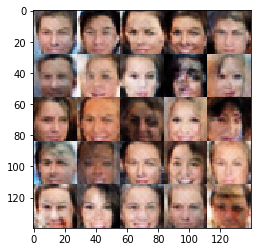

Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.7022


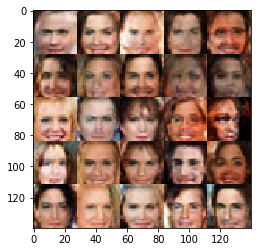

Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.6572


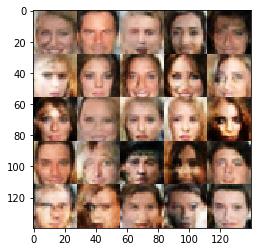

Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.6621


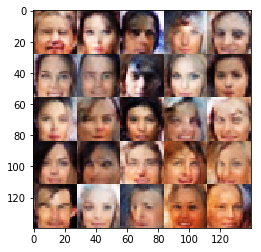

Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.8570


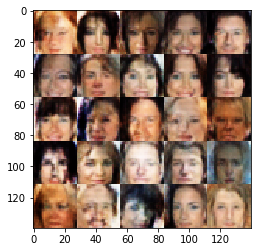

Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.7801


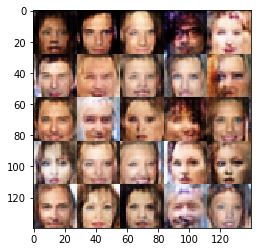

Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.7650


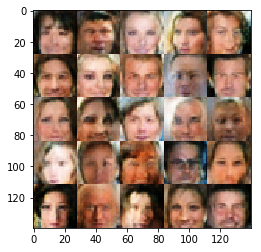

Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.8209


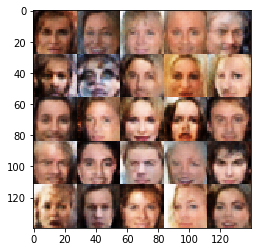

Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.8618


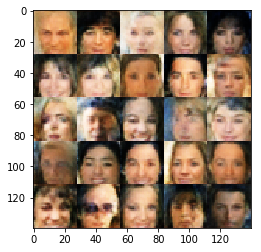

Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.7270


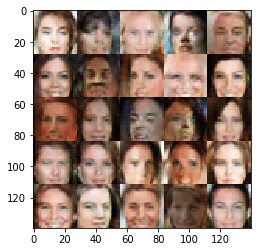

Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.7743


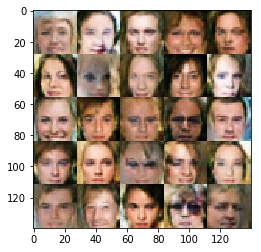

Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.6850


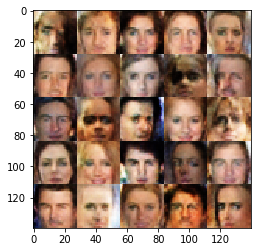

Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.9311


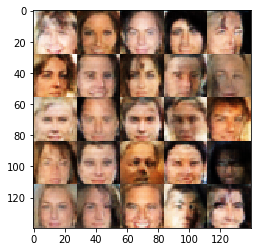

Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.6140


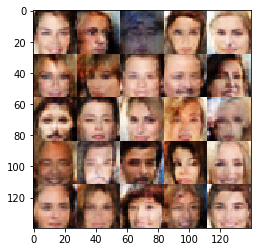

Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6936


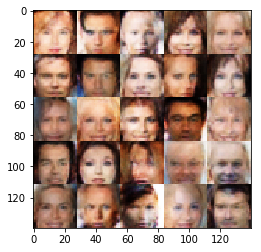

Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.7685


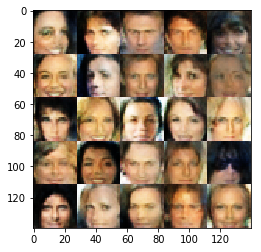

Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.8622


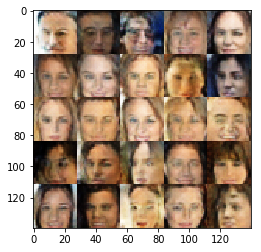

Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.7930


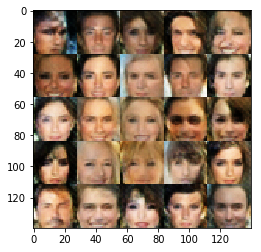

Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.8620


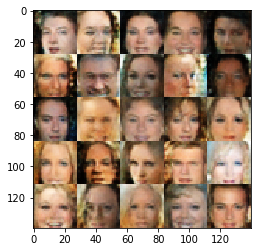

Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.7578


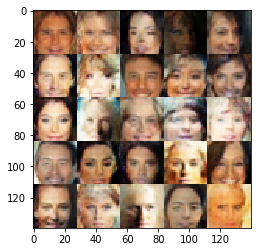

Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.8709


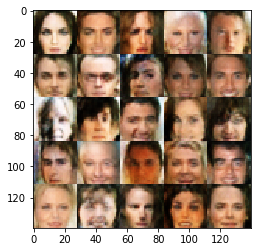

Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.7123


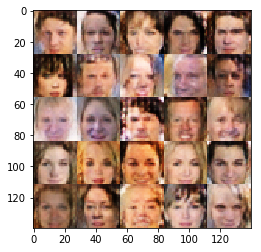

Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.6955


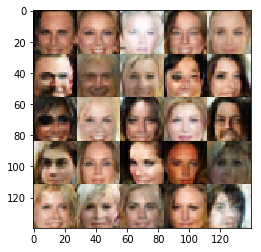

Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7420


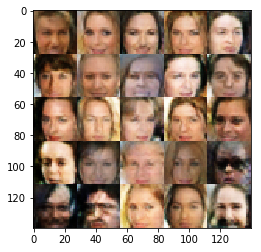

Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.6358


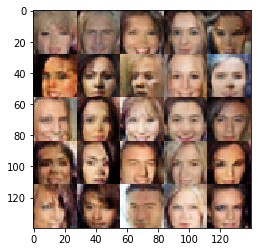

Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.7428


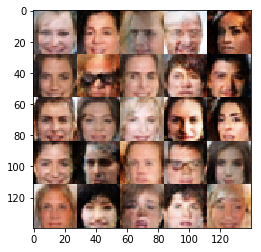

Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 0.7359


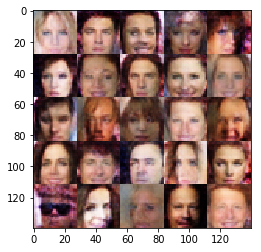

Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.6940


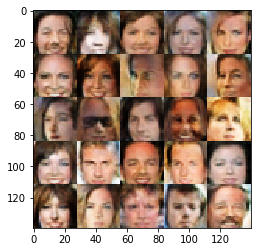

Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.6806


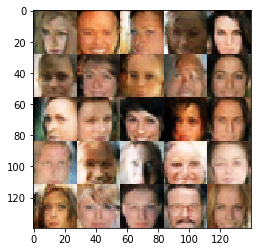

Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.7959


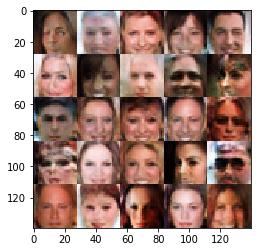

Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.8524


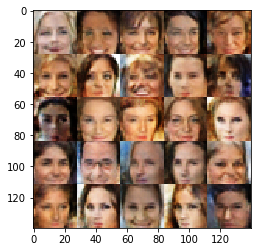

Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.7764


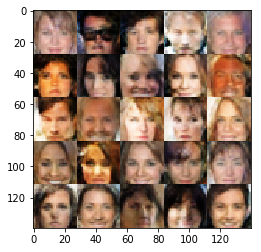

In [19]:
batch_size = 16
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.